In [ ]:
# Importando bibliotecas
import fastf1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from typing import Tuple, List, Optional, Dict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, mean_absolute_error, mean_squared_error,
    r2_score, explained_variance_score
)

In [3]:
def add_weather_info(session, stints_df):
    """
    Adds mean weather information from the session to the stints dataframe
    
    Args:
        session: FastF1 session object containing weather data
        stints_df: DataFrame containing stint data
        
    Returns:
        DataFrame with added weather columns
    """
    # Get weather data from session
    weather = session.weather_data
    
    # Calculate mean values
    mean_weather = weather.mean()
    
    # Add weather columns with broadcast values
    for col in mean_weather.index:
        stints_df[col] = mean_weather[col]
        
    return stints_df


def add_starting_positions(session, stints_df):
    """
    Adds starting grid position for each driver in the stints dataframe
    
    Args:
        session: FastF1 session object containing grid position info
        stints_df: DataFrame containing stint data
        
    Returns:
        DataFrame with added StartingPosition column
    """
    # Get starting grid positions
    grid = session.results[['Abbreviation', 'GridPosition']]
    grid = grid.set_index('Abbreviation')
    grid_dict = grid['GridPosition'].to_dict()
    
    # Add starting position column based on driver
    stints_df['StartingPosition'] = stints_df['Driver'].map(grid_dict)
    
    return stints_df


def add_team_info(session, stints_df):
    """
    Adds team information for each driver in the stints dataframe
    
    Args:
        session: FastF1 session object containing driver info
        stints_df: DataFrame containing stint data
        
    Returns:
        DataFrame with added Team column
    """
    # Create driver to team mapping
    driver_teams = {}
    for driver in session.drivers:
        driver_info = session.get_driver(driver)
        driver_teams[driver_info['Abbreviation']] = driver_info['TeamName']
    
    # Add team column based on driver
    stints_df['Team'] = stints_df['Driver'].map(driver_teams)
    
    return stints_df


def get_stints_race(session):
    laps = session.laps
    drivers = session.drivers
    drivers = [session.get_driver(driver)["Abbreviation"] for driver in drivers]
    stints = laps[["Driver", "Stint", "Compound", "LapNumber"]]
    stints = stints.groupby(["Driver", "Stint", "Compound"])
    stints = stints.count().reset_index()
    stints = stints.rename(columns={"LapNumber": "StintLength"})
    return stints


# for year in range(2024, 2025):
    # # Get the calendar for the year
    # calendar = fastf1.get_event_schedule(year, include_testing=False)
    #
    # # Initialize an empty list to store all stints data
    # all_stints = []
    #
    # # Loop through each race in the calendar
    # for idx, event in calendar.iterrows():
    #     try:
    #         # Load the race session
    #         session = fastf1.get_session(year, event['EventName'], 'R')
    #         session.load()
    #
    #         # Get stints for this race
    #         race_stints = get_stints_race(session)
    #
    #         # Add the team names for each row
    #         race_stints = add_team_info(session, race_stints)
    #
    #         # Add the starting position for each driver
    #         race_stints = add_starting_positions(session, race_stints)
    #
    #         # Add mean weather information
    #         race_stints = add_weather_info(session, race_stints)
    #
    #         # Add year and circuit information
    #         race_stints['Year'] = year
    #         race_stints['Circuit'] = event['EventName']
    #
    #         # Append to our list
    #         all_stints.append(race_stints)
    #
    #         print(f"Processed {year} {event['EventName']}")
    #     except Exception as e:
    #         print(f"Error processing {year} {event['EventName']}: {e}")
    #
    # # If we have data for this year, concatenate it
    # if all_stints:
    #     year_stints = pd.concat(all_stints, ignore_index=True)
    #
    #     # Save the data for this year (optional)
    #     year_stints.to_csv(f"stints_data_{year}.csv", index=False)

In [4]:
stints_2019 = pd.read_csv("stints_data_2019.csv", index_col=None)
stints_2020 = pd.read_csv("stints_data_2020.csv", index_col=None)
stints_2021 = pd.read_csv("stints_data_2021.csv", index_col=None)
stints_2022 = pd.read_csv("stints_data_2022.csv", index_col=None)
stints_2023 = pd.read_csv("stints_data_2023.csv", index_col=None)
stints_2024 = pd.read_csv("stints_data_2024.csv", index_col=None)

stints = pd.concat([stints_2019, stints_2020, stints_2021, stints_2022, stints_2023, stints_2024])
stints

,Driver,Stint,Compound,StintLength,Team,StartingPosition,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year,Circuit
0,ALB,1.0,SOFT,14,Toro Rosso,13.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,0.0,41.313115,155.327869,1.166393,2019,Australian Grand Prix
1,ALB,2.0,MEDIUM,43,Toro Rosso,13.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,0.0,41.313115,155.327869,1.166393,2019,Australian Grand Prix
2,BOT,1.0,SOFT,23,Mercedes,2.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,0.0,41.313115,155.327869,1.166393,2019,Australian Grand Prix
3,BOT,2.0,MEDIUM,35,Mercedes,2.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,0.0,41.313115,155.327869,1.166393,2019,Australian Grand Prix
4,GAS,1.0,MEDIUM,37,Red Bull Racing,17.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,0.0,41.313115,155.327869,1.166393,2019,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,VER,1.0,MEDIUM,29,Red Bull Racing,4.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,0.0,31.805405,137.033784,1.900676,2024,Abu Dhabi Grand Prix
1298,VER,2.0,HARD,29,Red Bull Racing,4.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,0.0,31.805405,137.033784,1.900676,2024,Abu Dhabi Grand Prix
1299,ZHO,1.0,MEDIUM,12,Kick Sauber,15.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,0.0,31.805405,137.033784,1.900676,2024,Abu Dhabi Grand Prix
1300,ZHO,2.0,HARD,27,Kick Sauber,15.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,0.0,31.805405,137.033784,1.900676,2024,Abu Dhabi Grand Prix


In [5]:
stints_better_vis = stints.astype({
    "Stint": "int",
})
stints_better_vis

,Driver,Stint,Compound,StintLength,Team,StartingPosition,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,Year,Circuit
0,ALB,1,SOFT,14,Toro Rosso,13.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,0.0,41.313115,155.327869,1.166393,2019,Australian Grand Prix
1,ALB,2,MEDIUM,43,Toro Rosso,13.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,0.0,41.313115,155.327869,1.166393,2019,Australian Grand Prix
2,BOT,1,SOFT,23,Mercedes,2.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,0.0,41.313115,155.327869,1.166393,2019,Australian Grand Prix
3,BOT,2,MEDIUM,35,Mercedes,2.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,0.0,41.313115,155.327869,1.166393,2019,Australian Grand Prix
4,GAS,1,MEDIUM,37,Red Bull Racing,17.0,0 days 01:00:46.617934426,23.477869,70.453279,1015.334426,0.0,41.313115,155.327869,1.166393,2019,Australian Grand Prix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,VER,1,MEDIUM,29,Red Bull Racing,4.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,0.0,31.805405,137.033784,1.900676,2024,Abu Dhabi Grand Prix
1298,VER,2,HARD,29,Red Bull Racing,4.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,0.0,31.805405,137.033784,1.900676,2024,Abu Dhabi Grand Prix
1299,ZHO,1,MEDIUM,12,Kick Sauber,15.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,0.0,31.805405,137.033784,1.900676,2024,Abu Dhabi Grand Prix
1300,ZHO,2,HARD,27,Kick Sauber,15.0,0 days 01:14:27.206128378,26.768243,51.445946,1017.426351,0.0,31.805405,137.033784,1.900676,2024,Abu Dhabi Grand Prix


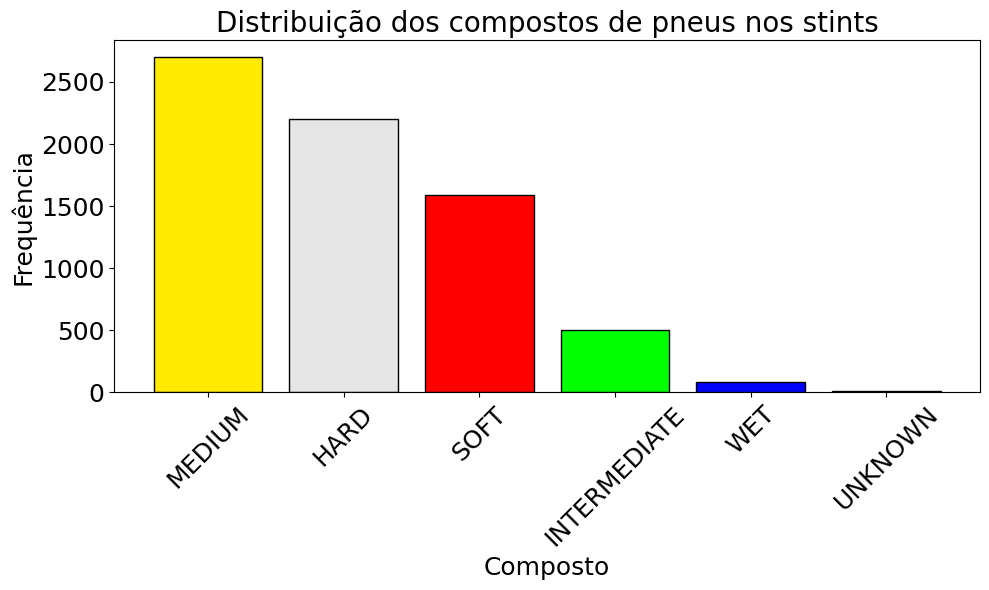

In [6]:
def plot_compound_histogram(stints: pd.DataFrame, font_size: int = 18) -> None:
    """
    Plota um gráfico de barras dos compostos de pneus usados no DataFrame 'stints',
    colorindo cada barra com as cores oficiais da F1 para cada composto e com fundo transparente.
    Permite ajustar o tamanho da fonte do título, rótulos e ticks.

    Parâmetros
    ----------
    stints : pd.DataFrame
        Deve conter uma coluna 'Compound' com valores em
        {'HARD', 'SOFT', 'INTERMEDIATE', 'WET', 'UNKNOWN'}.
    font_size : int, opcional
        Tamanho base da fonte para título, rótulos e ticks (padrão: 12).
    """
    # Cores hex exatas dos compostos da F1; HARD mapeado para cinza claro em vez de branco
    colour_map: Dict[str, str] = {
        "HARD": "#E6E6E6",         # cinza claro
        "MEDIUM": "#FFEA00",       # amarelo (Medium oficial)
        "SOFT": "#FF0000",         # vermelho
        "INTERMEDIATE": "#00FF00", # verde
        "WET": "#0000FF",          # azul
        "UNKNOWN": "#808080"       # cinza
    }

    # Garantir a ordem consistente dos compostos
    compostos = ["MEDIUM", "HARD", "SOFT", "INTERMEDIATE", "WET", "UNKNOWN"]
    contagens = stints["Compound"].value_counts().reindex(compostos, fill_value=0)

    # Lista de cores para as barras
    bar_colors = [colour_map[c] for c in contagens.index]

    # Plotagem com fundo transparente
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="none")
    ax.set_facecolor("none")
    ax.bar(contagens.index, contagens.values, color=bar_colors, edgecolor="black")

    # Ajuste de fontes
    ax.set_title("Distribuição dos compostos de pneus nos stints", fontsize=font_size + 2)
    ax.set_xlabel("Composto", fontsize=font_size)
    ax.set_ylabel("Frequência", fontsize=font_size)
    ax.tick_params(axis='x', rotation=45, labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    plt.tight_layout()
    plt.show()

# Plot the histogram
plot_compound_histogram(stints)

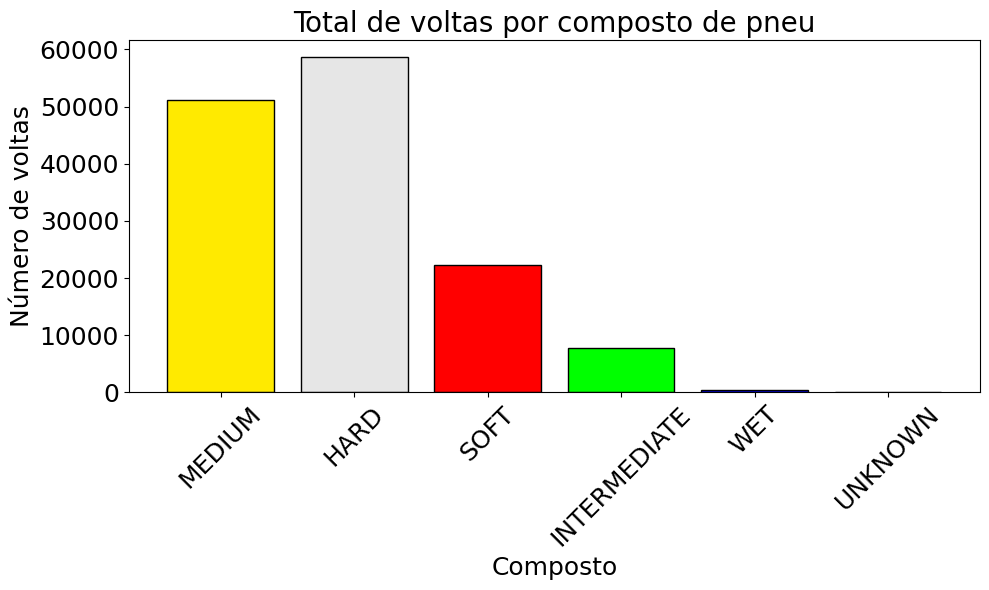

In [7]:
def plot_compound_laps(stints: pd.DataFrame, font_size: int = 18) -> None:
    """
    Plota um gráfico de barras da quantidade total de voltas por composto de pneu,
    colorindo cada barra com as cores oficiais da F1 para cada composto e com fundo transparente.
    Permite ajustar o tamanho da fonte do título, rótulos e ticks.

    Parâmetros
    ----------
    stints : pd.DataFrame
        Deve conter uma coluna 'Compound' com valores em
        {'HARD', 'SOFT', 'INTERMEDIATE', 'WET', 'UNKNOWN'} e uma coluna 'StintLength'
        com o número de voltas de cada stint.
    font_size : int, opcional
        Tamanho base da fonte para título, rótulos e ticks (padrão: 18).
    """
    # Cores hex exatas dos compostos da F1; HARD mapeado para cinza claro em vez de branco
    colour_map: Dict[str, str] = {
        "HARD": "#E6E6E6",         # cinza claro
        "MEDIUM": "#FFEA00",       # amarelo (Medium oficial)
        "SOFT": "#FF0000",         # vermelho
        "INTERMEDIATE": "#00FF00", # verde
        "WET": "#0000FF",          # azul
        "UNKNOWN": "#808080"       # cinza
    }

    # Garantir a ordem consistente dos compostos
    compostos = ["MEDIUM", "HARD", "SOFT", "INTERMEDIATE", "WET", "UNKNOWN"]

    # Somar as voltas por composto
    voltas_por_composto = stints.groupby("Compound")["StintLength"].sum().reindex(compostos, fill_value=0)

    # Lista de cores para as barras
    bar_colors = [colour_map[c] for c in voltas_por_composto.index]

    # Plotagem com fundo transparente
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="none")
    ax.set_facecolor("none")
    ax.bar(voltas_por_composto.index, voltas_por_composto.values, color=bar_colors, edgecolor="black")

    # Ajuste de fontes
    ax.set_title("Total de voltas por composto de pneu", fontsize=font_size + 2)
    ax.set_xlabel("Composto", fontsize=font_size)
    ax.set_ylabel("Número de voltas", fontsize=font_size)
    ax.tick_params(axis='x', rotation=45, labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    plt.tight_layout()
    plt.show()

# Plot the laps histogram
plot_compound_laps(stints)

In [8]:
def transform_stints_data(df):
    """
    Transform stints data into a format where each row represents a driver's complete race strategy.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing stints data.
        
    Returns:
    --------
    pandas.DataFrame
        Transformed DataFrame with compounds consolidated into lists,
        stint lengths consolidated into lists.
    """
    grouped = df.groupby(['Driver', 'Year', 'Circuit'])
    
    transformed = pd.DataFrame({
        'Compounds': grouped['Compound'].apply(list),
        'StintLengths': grouped['StintLength'].apply(list),
        'Team': grouped['Team'].first(),
        'StartingPosition': grouped['StartingPosition'].first(),
        'AirTemp': grouped['AirTemp'].first(),
        'Humidity': grouped['Humidity'].first(), 
        'Pressure': grouped['Pressure'].first(),
        'Rainfall': grouped['Rainfall'].first(),
        'TrackTemp': grouped['TrackTemp'].first(),
        'WindDirection': grouped['WindDirection'].first(),
        'WindSpeed': grouped['WindSpeed'].first()
    }).reset_index()

    # Remove estratégias contendo compostos UNKNOWN, INTERMEDIATE ou WET 
    transformed = transformed[~transformed['Compounds'].apply(lambda compounds: 
        any(compound in compounds for compound in ['UNKNOWN', 'INTERMEDIATE', 'WET']))]
    
    # Remove estratégias com apenas um composto (provavelmente corridas não terminadas)
    transformed = transformed[transformed['Compounds'].apply(len) > 1]
    
    return transformed

transformed_stints = transform_stints_data(stints)
transformed_stints

,Driver,Year,Circuit,Compounds,StintLengths,Team,StartingPosition,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,AIT,2020,Sakhir Grand Prix,"[MEDIUM, HARD, MEDIUM, SOFT]","[31, 23, 5, 28]",Williams,17.0,20.947244,58.169291,1015.941732,0.000000,23.469291,122.755906,1.948031
1,ALB,2019,Abu Dhabi Grand Prix,"[MEDIUM, HARD]","[13, 42]",Red Bull Racing,5.0,26.018045,64.471429,1015.383459,0.000000,29.566165,221.097744,1.264662
2,ALB,2019,Australian Grand Prix,"[SOFT, MEDIUM]","[14, 43]",Toro Rosso,13.0,23.477869,70.453279,1015.334426,0.000000,41.313115,155.327869,1.166393
3,ALB,2019,Austrian Grand Prix,"[MEDIUM, HARD]","[35, 35]",Toro Rosso,18.0,34.444068,17.965254,940.888983,0.000000,50.744068,188.855932,1.225424
4,ALB,2019,Azerbaijan Grand Prix,"[SOFT, MEDIUM]","[12, 38]",Toro Rosso,11.0,19.763566,51.408527,1013.775194,0.000000,39.654264,167.480620,1.249612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2547,ZHO,2024,Qatar Grand Prix,"[MEDIUM, HARD, HARD, HARD]","[35, 1, 1, 20]",Kick Sauber,12.0,18.926490,57.251656,1015.500000,0.000000,22.773510,105.649007,1.657616
2548,ZHO,2024,Saudi Arabian Grand Prix,"[MEDIUM, SOFT]","[41, 8]",Kick Sauber,20.0,25.528082,62.335616,1012.682877,0.000000,31.593151,129.143836,1.302740
2549,ZHO,2024,Singapore Grand Prix,"[HARD, MEDIUM]","[34, 27]",Kick Sauber,20.0,30.786250,74.650000,1008.024375,0.000000,36.445625,192.493750,0.955000
2550,ZHO,2024,Spanish Grand Prix,"[SOFT, MEDIUM, HARD]","[9, 32, 24]",Kick Sauber,15.0,24.132468,63.441558,1001.356494,0.006494,41.096104,207.370130,2.123377


In [11]:
# Show the value counts of the len of compounds
print(transformed_stints['Compounds'].apply(len).value_counts().sort_index())

Compounds
2    893
3    838
4    283
5     75
6     19
7      6
Name: count, dtype: int64


Compounds
2    893
3    838
4    283
5     75
6     19
7      6
Name: count, dtype: int64


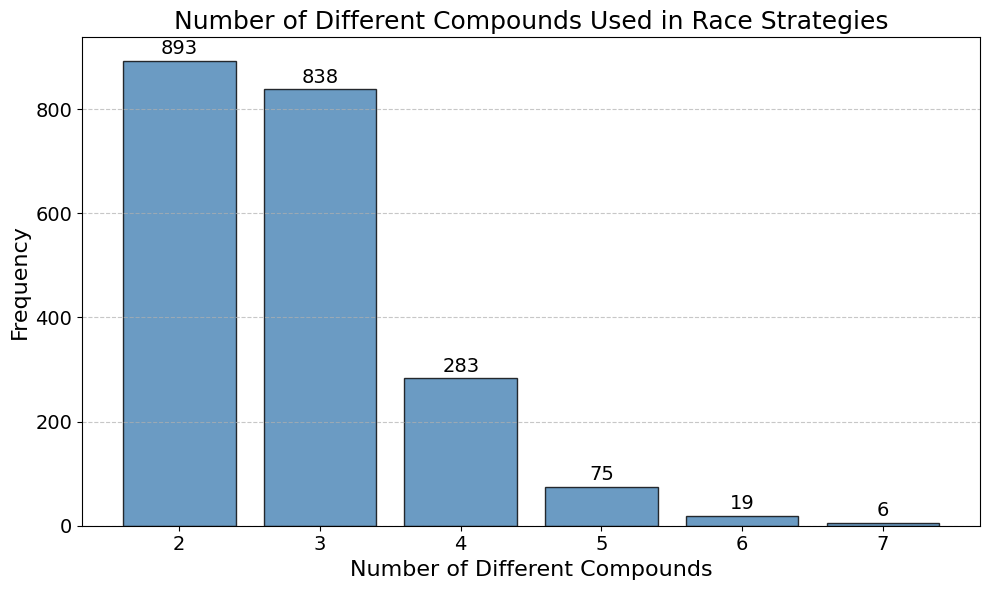

In [16]:
def plot_strategy_compounds_count(df: pd.DataFrame, font_size: int = 14) -> None:
    """
    Creates a histogram showing the frequency of the number of compounds used in race strategies.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing transformed stint data with a 'Compounds' column.
    font_size : int, optional
        Base font size for the plot (default: 14).
    """
    # Count number of unique compounds in each strategy
    compound_counts = df['Compounds'].apply(lambda x: len(x))
    # Create the plot with custom aesthetics
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="none")
    ax.set_facecolor("none")
    
    # Create histogram with counts
    counts = compound_counts.value_counts().sort_index()
    
    # Convert to regular Python integers to avoid typing issues
    x_values = [int(x) for x in counts.index]
    y_values = [int(y) for y in counts.values]
 
    bars = ax.bar(x_values, y_values, color='steelblue', edgecolor='black', alpha=0.8)
    
    # Add value labels above bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{int(height)}', ha='center', va='bottom', fontsize=font_size)
    
    # Customize the plot
    ax.set_title('Number of Different Compounds Used in Race Strategies', fontsize=font_size + 4)
    ax.set_xlabel('Number of Different Compounds', fontsize=font_size + 2)
    ax.set_ylabel('Frequency', fontsize=font_size + 2)
    ax.tick_params(axis='both', labelsize=font_size)
    
    # Set x-axis to show only integers
    ax.set_xticks(counts.index) # Ou você pode usar ax.set_xticks(x_values)
    
    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

print(transformed_stints['Compounds'].apply(len).value_counts().sort_index())
plot_strategy_compounds_count(transformed_stints)

In [17]:
transformed_stints['Circuit'].value_counts()

Circuit
Spanish Grand Prix             119
Bahrain Grand Prix             117
Abu Dhabi Grand Prix           116
Austrian Grand Prix            115
Italian Grand Prix             111
United States Grand Prix        95
Azerbaijan Grand Prix           95
Belgian Grand Prix              91
British Grand Prix              90
Hungarian Grand Prix            80
Mexico City Grand Prix          74
Saudi Arabian Grand Prix        74
Australian Grand Prix           73
Monaco Grand Prix               62
Dutch Grand Prix                60
Miami Grand Prix                59
French Grand Prix               59
Singapore Grand Prix            58
Japanese Grand Prix             57
Canadian Grand Prix             56
Qatar Grand Prix                56
São Paulo Grand Prix            55
Chinese Grand Prix              40
Portuguese Grand Prix           39
Las Vegas Grand Prix            39
Emilia Romagna Grand Prix       39
Russian Grand Prix              37
Styrian Grand Prix              37
Mexican Gran

In [18]:
corrections = {
    '70th Anniversary Grand Prix': 'Silverstone Circuit',
    'British Grand Prix': 'Silverstone Circuit',
    'Sao Paulo Grand Prix': 'Interlagos Circuit',
    'Brazilian Grand Prix': 'Interlagos Circuit',
    'Abu Dhabi Grand Prix': 'Yas Marina Circuit',
    'Australian Grand Prix': 'Albert Park Circuit',
    'Azerbaijan Grand Prix': 'Baku City Circuit',
    'Bahrain Grand Prix': 'Bahrain International Circuit - 57 laps',
    'Belgian Grand Prix': 'Circuit de Spa-Francorchamps',
    'Canadian Grand Prix': 'Circuit Gilles Villeneuve',
    'Chinese Grand Prix': 'Shanghai International Circuit',
    'Dutch Grand Prix': 'Circuit Zandvoort',
    'Eifel Grand Prix': 'Nürburgring GP-Strecke Circuit',
    'French Grand Prix': 'Circuit Paul Ricard',
    'Emilia Romagna Grand Prix': 'Autodromo Enzo e Dino Ferrari',
    'German Grand Prix': 'Hockenheimring Circuit',
    'Hungarian Grand Prix': 'Hungaroring Circuit',
    'Italian Grand Prix': 'Autodromo Nazionale Monza',
    'Japanese Grand Prix': 'Suzuka Circuit',
    'Las Vegas Grand Prix': 'Las Vegas Strip Circuit',
    'Mexican Grand Prix': 'Autódromo Hermanos Rodríguez',
    'Mexico City Grand Prix': 'Autódromo Hermanos Rodríguez',
    'Miami Grand Prix': 'Miami International Autodrome',
    'Monaco Grand Prix': 'Circuit de Monaco',
    'Portuguese Grand Prix': 'Algarve International Circuit',
    'Qatar Grand Prix': 'Lusail International Circuit',
    'Russian Grand Prix': 'Sochi Autodrom',
    'Sakhir Grand Prix': 'Bahrain International Circuit - 87 laps',
    'Saudi Arabian Grand Prix': 'Jeddah Corniche Circuit',
    'Singapore Grand Prix': 'Marina Bay Street Circuit',
    'Spanish Grand Prix': 'Circuit de Barcelona-Catalunya',
    'Styrian Grand Prix': 'Red Bull Ring',
    'Turkish Grand Prix': 'Istanbul Park',
    'Tuscan Grand Prix': 'Autodromo del Mugello',
    'United States Grand Prix': 'Circuit of the Americas',
}

# Apply the corrections using the map function
transformed_stints['Circuit'] = transformed_stints['Circuit'].map(corrections)
# Check for any unmapped values
unmapped_circuits = transformed_stints[transformed_stints['Circuit'].isna()]['Circuit'].unique()

In [19]:
transformed_stints.to_csv(".\\stints_2019-2024.csv")

In [20]:
def prepare_df(df: pd.DataFrame, max_stints: int = 4) -> pd.DataFrame:
    """
    Prepares the DataFrame for modeling:
    1. Filters out entries with more than max_stints.
    2. Pads the 'Compounds' and 'StintLengths' lists.
    3. Explodes these lists into separate columns for each stint.
    """
    # 1. Filter rows with too many stints
    # Ensure original df is not modified if it's used elsewhere
    df_copy = df[df['StintLengths'].map(len) <= max_stints].copy()

    # 2. Pad lists to ensure uniform length
    df_copy['Compounds_padded'] = df_copy['Compounds'].map(
        lambda lst: lst + ['NONE'] * (max_stints - len(lst))
    )
    df_copy['Lengths_padded'] = df_copy['StintLengths'].map(
        lambda lst: lst + [0] * (max_stints - len(lst)) # Using 0 as padding for lengths
    )

    # 3. Explode lists into separate columns for each stint
    for i in range(max_stints):
        df_copy[f'Compound_{i+1}'] = df_copy['Compounds_padded'].str[i]
        df_copy[f'Length_{i+1}']   = df_copy['Lengths_padded'].str[i]
    return df_copy

In [21]:
def build_feature_matrix(df: pd.DataFrame, max_stints: int) -> Tuple[
    pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, 
    pd.DataFrame, pd.DataFrame, List[LabelEncoder], StandardScaler
]:
    """
    Builds feature and target matrices, splits data, and preprocesses:
    1. Defines feature and target column names based on max_stints.
    2. Splits data into training and testing sets *before* any fitting.
    3. Scales numeric features (StandardScaler fit on train, transform train/test).
    4. Encodes categorical compound targets (LabelEncoder fit on train, transform train/test).
    Returns:
        X_train_scaled, X_test_scaled,
        yc_train_encoded, yc_test_encoded,
        yl_train, yl_test,
        encoders (for compounds), scaler (for features)
    """
    # Define feature columns (ensure these columns exist in df)
    # Your original feature set:
    feature_cols = ['Year','StartingPosition','AirTemp','Humidity',
                    'Pressure','Rainfall','TrackTemp','WindDirection','WindSpeed']
    # Consider adding 'Driver', 'Circuit', 'Team' after appropriate encoding (e.g., OneHotEncoder)
    
    # Define target column names dynamically using max_stints
    compound_target_cols = [f'Compound_{i+1}' for i in range(max_stints)]
    length_target_cols = [f'Length_{i+1}' for i in range(max_stints)]

    # Ensure all specified columns are present in the DataFrame
    missing_cols = [col for col in feature_cols + compound_target_cols + length_target_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in DataFrame: {missing_cols}")

    X = df[feature_cols]
    y_comp_raw = df[compound_target_cols].copy() # Raw compound strings
    y_len = df[length_target_cols].copy()        # Lengths are already numeric

    # Split data *before* any fitting to prevent data leakage
    X_train, X_test, \
    yc_train_raw, yc_test_raw, \
    yl_train, yl_test = train_test_split(
        X, y_comp_raw, y_len,
        test_size=0.20,
        random_state=72,
        shuffle=True
    )

    # --- Preprocess Features (Scaling) ---
    scaler = StandardScaler()
    # Fit scaler ONLY on training data's numeric features
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train), 
        columns=X_train.columns, 
        index=X_train.index
    )
    # Transform test data using the SAME fitted scaler
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test), 
        columns=X_test.columns, 
        index=X_test.index
    )

    # --- Preprocess Compound Targets (Label Encoding) ---
    encoders: List[LabelEncoder] = []
    yc_train_encoded = yc_train_raw.copy()
    yc_test_encoded = yc_test_raw.copy()

    all_compounds = ['SOFT', 'MEDIUM', 'HARD', 'NONE', 'WET', 'INTERMEDIATE']
    for col in compound_target_cols:
        le = LabelEncoder()
        # Fit LabelEncoder ONLY on the training data for this target column
        le.fit(all_compounds)
        
        # Transform both training and testing data for this column
        yc_train_encoded[col] = le.transform(yc_train_raw[col])
        yc_test_encoded[col] = le.transform(yc_test_raw[col])
        
        encoders.append(le)
    
    return X_train_scaled, X_test_scaled, yc_train_encoded, yc_test_encoded, yl_train, yl_test, encoders, scaler

In [22]:
def train_and_eval(X_train: pd.DataFrame, X_test: pd.DataFrame,
                   yc_train: pd.DataFrame, yc_test: pd.DataFrame,  # Encoded compound targets
                   yl_train: pd.DataFrame, yl_test: pd.DataFrame,  # Stint length targets
                   encoders: List[LabelEncoder]  # <-- New argument: list of fitted LabelEncoders for compounds
                   ) -> tuple: # Adjusted return type hint if you want to be specific
    """
    Trains compound and stint length models, evaluates them, 
    and creates DataFrames for side-by-side comparison of predictions and actuals.

    Args:
        X_train: Training features.
        X_test: Testing features.
        yc_train: Encoded training compound labels.
        yc_test: Encoded testing compound labels.
        yl_train: Training stint lengths.
        yl_test: Testing stint lengths.
        encoders: List of fitted LabelEncoder objects for each compound target column.

    Returns:
        A tuple containing:
            - clf_model: Trained multi-output classifier for compounds.
            - reg_model: Trained multi-output regressor for stint lengths.
            - compounds_comparison_df: DataFrame comparing actual and predicted compounds (decoded).
            - lengths_comparison_df: DataFrame comparing actual and predicted stint lengths.
    """
    # 1) Compounds model (RandomForestClassifier)
    clf_model = MultiOutputClassifier(RandomForestClassifier(
        n_estimators=100, random_state=72, n_jobs=-1
    ))
    clf_model.fit(X_train, yc_train)
    # yc_pred will contain encoded predictions
    yc_pred = pd.DataFrame(clf_model.predict(X_test), columns=yc_test.columns, index=X_test.index)

    # 2) Lengths model (RandomForestRegressor)
    reg_model = MultiOutputRegressor(RandomForestRegressor(
        n_estimators=100, random_state=72, n_jobs=-1
    ))
    reg_model.fit(X_train, yl_train)
    # yl_pred will contain float predictions
    yl_pred = pd.DataFrame(reg_model.predict(X_test), columns=yl_test.columns, index=X_test.index)

    # 3) Metrics
    # Compounds: overall accuracy on encoded labels
    comp_acc = np.mean([
        accuracy_score(yc_test[col], yc_pred[col])
        for col in yc_test.columns
    ])
    # Lengths: mean absolute error
    length_mae = mean_absolute_error(yl_test, yl_pred)

    print(f"Compound accuracy (avg over slots, encoded): {comp_acc:.3f}")
    print(f"Length MAE (all slots): {length_mae:.3f}")

    # 4) Create Comparison DataFrames

    # --- Compounds Comparison (Decoded) ---
    # `encoders` list should correspond to the order of columns in yc_test/yc_pred
    compound_comparison_cols = {}
    for i, col_name in enumerate(yc_test.columns):
        encoder = encoders[i] # Get the specific encoder for this compound stint
        compound_comparison_cols[f'{col_name}_Actual'] = encoder.inverse_transform(yc_test[col_name])
        compound_comparison_cols[f'{col_name}_Predicted'] = encoder.inverse_transform(yc_pred[col_name])
    
    compounds_comparison_df = pd.DataFrame(compound_comparison_cols, index=X_test.index)
    # Reorder columns for better side-by-side view if many stints
    ordered_compound_cols = []
    for col_name in yc_test.columns: # e.g., Compound_1, Compound_2
        ordered_compound_cols.append(f'{col_name}_Actual')
        ordered_compound_cols.append(f'{col_name}_Predicted')
    compounds_comparison_df = compounds_comparison_df[ordered_compound_cols]


    # --- Stint Lengths Comparison ---
    # Round predicted lengths to the nearest integer for better comparison
    yl_pred_rounded = yl_pred.round().astype(int)

    length_comparison_cols = {}
    for col_name in yl_test.columns: # e.g., Length_1, Length_2
        length_comparison_cols[f'{col_name}_Actual'] = yl_test[col_name]
        length_comparison_cols[f'{col_name}_Predicted'] = yl_pred_rounded[col_name]
        
    lengths_comparison_df = pd.DataFrame(length_comparison_cols, index=X_test.index)
    # Reorder columns
    ordered_length_cols = []
    for col_name in yl_test.columns:
        ordered_length_cols.append(f'{col_name}_Actual')
        ordered_length_cols.append(f'{col_name}_Predicted')
    lengths_comparison_df = lengths_comparison_df[ordered_length_cols]

    return clf_model, reg_model, compounds_comparison_df, lengths_comparison_df

In [23]:
def train_and_eval(X_train: pd.DataFrame, X_test: pd.DataFrame,
                   yc_train: pd.DataFrame, yc_test: pd.DataFrame,  # Encoded compound targets
                   yl_train: pd.DataFrame, yl_test: pd.DataFrame,  # Stint length targets
                   encoders: List[LabelEncoder]  # <-- New argument: list of fitted LabelEncoders for compounds
                   ) -> tuple: # Adjusted return type hint if you want to be specific
    """
    Trains compound and stint length models, evaluates them,
    and creates DataFrames for side-by-side comparison of predictions and actuals.

    Args:
        X_train: Training features.
        X_test: Testing features.
        yc_train: Encoded training compound labels.
        yc_test: Encoded testing compound labels.
        yl_train: Training stint lengths.
        yl_test: Testing stint lengths.
        encoders: List of fitted LabelEncoder objects for each compound target column.

    Returns:
        A tuple containing:
            - clf_model: Trained multi-output classifier for compounds.
            - reg_model: Trained multi-output regressor for stint lengths.
            - compounds_comparison_df: DataFrame comparing actual and predicted compounds (decoded).
            - lengths_comparison_df: DataFrame comparing actual and predicted stint lengths.
    """
    # 1) Compounds model (RandomForestClassifier)
    clf_model = MultiOutputClassifier(RandomForestClassifier(
        n_estimators=100, random_state=72, n_jobs=-1
    ))
    clf_model.fit(X_train, yc_train)
    # yc_pred will contain encoded predictions
    yc_pred = pd.DataFrame(clf_model.predict(X_test), columns=yc_test.columns, index=X_test.index)

    # 2) Lengths model (RandomForestRegressor)
    reg_model = MultiOutputRegressor(RandomForestRegressor(
        n_estimators=100, random_state=72, n_jobs=-1
    ))
    reg_model.fit(X_train, yl_train)
    # yl_pred will contain float predictions
    yl_pred = pd.DataFrame(reg_model.predict(X_test), columns=yl_test.columns, index=X_test.index)

    # 3) Metrics
    # === COMPOUND CLASSIFICATION METRICS ===
    # Accuracy (overall)
    comp_acc = np.mean([
        accuracy_score(yc_test[col], yc_pred[col])
        for col in yc_test.columns
    ])

    # Precision (macro average)
    comp_precision = np.mean([
        precision_score(yc_test[col], yc_pred[col], average='macro', zero_division=0)
        for col in yc_test.columns
    ])

    # Recall (macro average)
    comp_recall = np.mean([
        recall_score(yc_test[col], yc_pred[col], average='macro', zero_division=0)
        for col in yc_test.columns
    ])

    # F1-score (macro average)
    comp_f1 = np.mean([
        f1_score(yc_test[col], yc_pred[col], average='macro', zero_division=0)
        for col in yc_test.columns
    ])

    # Classification Report for first compound (as example)
    for col_name in yc_test.columns:
        print(f"\nClassification Report for {col_name}:")
        print(classification_report(yc_test[col_name], yc_pred[col_name]))

    print("\n" + "="*50)
    print("COMPOUND LABEL MAPPINGS:")
    for i, col_name in enumerate(yc_test.columns):
        print(f"\n{col_name} mapping:")
        encoder = encoders[i]
        unique_encoded = np.unique(yc_test[col_name])
        for encoded_val in unique_encoded:
            original_name = encoder.inverse_transform([encoded_val])[0]
            print(f"  {encoded_val} -> {original_name}")

    # === REGRESSION METRICS ===
    # Mean Absolute Error
    length_mae = mean_absolute_error(yl_test, yl_pred)

    # Mean Squared Error
    length_mse = mean_squared_error(yl_test, yl_pred)

    # Root Mean Squared Error
    length_rmse = np.sqrt(length_mse)

    # R² Score
    length_r2 = r2_score(yl_test, yl_pred)

    # Mean Absolute Percentage Error
    # Avoid division by zero by adding small epsilon
    epsilon = 1e-8
    # length_mape = np.mean(np.abs((yl_test - yl_pred) / (yl_test + epsilon))) * 100

    # Explained Variance Score
    length_evs = explained_variance_score(yl_test, yl_pred)

    # Print all metrics
    print("="*50)
    print("COMPOUND CLASSIFICATION METRICS:")
    print(f"Accuracy (avg over slots): {comp_acc:.3f}")
    print(f"Precision (macro avg): {comp_precision:.3f}")
    print(f"Recall (macro avg): {comp_recall:.3f}")
    print(f"F1-Score (macro avg): {comp_f1:.3f}")

    print("\n" + "="*50)
    print("STINT LENGTH REGRESSION METRICS:")
    print(f"Mean Absolute Error (MAE): {length_mae:.3f}")
    print(f"Mean Squared Error (MSE): {length_mse:.3f}")
    print(f"Root Mean Squared Error (RMSE): {length_rmse:.3f}")
    print(f"R² Score: {length_r2:.3f}")
    # print(f"Mean Absolute Percentage Error (MAPE): {length_mape:.2f}%")
    print(f"Explained Variance Score: {length_evs:.3f}")
    print("="*50)

    # 4) Create Comparison DataFrames

    # --- Compounds Comparison (Decoded) ---
    # `encoders` list should correspond to the order of columns in yc_test/yc_pred
    compound_comparison_cols = {}
    for i, col_name in enumerate(yc_test.columns):
        encoder = encoders[i] # Get the specific encoder for this compound stint
        compound_comparison_cols[f'{col_name}_Actual'] = encoder.inverse_transform(yc_test[col_name])
        compound_comparison_cols[f'{col_name}_Predicted'] = encoder.inverse_transform(yc_pred[col_name])

    compounds_comparison_df = pd.DataFrame(compound_comparison_cols, index=X_test.index)
    # Reorder columns for better side-by-side view if many stints
    ordered_compound_cols = []
    for col_name in yc_test.columns: # e.g., Compound_1, Compound_2
        ordered_compound_cols.append(f'{col_name}_Actual')
        ordered_compound_cols.append(f'{col_name}_Predicted')
    compounds_comparison_df = compounds_comparison_df[ordered_compound_cols]


    # --- Stint Lengths Comparison ---
    # Round predicted lengths to the nearest integer for better comparison
    yl_pred_rounded = yl_pred.round().astype(int)

    length_comparison_cols = {}
    for col_name in yl_test.columns: # e.g., Length_1, Length_2
        length_comparison_cols[f'{col_name}_Actual'] = yl_test[col_name]
        length_comparison_cols[f'{col_name}_Predicted'] = yl_pred_rounded[col_name]

    lengths_comparison_df = pd.DataFrame(length_comparison_cols, index=X_test.index)
    # Reorder columns
    ordered_length_cols = []
    for col_name in yl_test.columns:
        ordered_length_cols.append(f'{col_name}_Actual')
        ordered_length_cols.append(f'{col_name}_Predicted')
    lengths_comparison_df = lengths_comparison_df[ordered_length_cols]

    return clf_model, reg_model, compounds_comparison_df, lengths_comparison_df

In [24]:
MAX_STINTS = 5 # Define this once

df_prepared = prepare_df(transformed_stints, max_stints=MAX_STINTS)

# Now, build_feature_matrix also takes max_stints
X_train, X_test, \
yc_train, yc_test, \
yl_train, yl_test, \
compound_encoders, feature_scaler = build_feature_matrix(df_prepared, max_stints=MAX_STINTS)

# Train and evaluate
clf_model, reg_model, compounds_comp_df, lengths_comp_df = train_and_eval(
    X_train, X_test, 
    yc_train, yc_test, 
    yl_train, yl_test,
    compound_encoders  # <-- Pass the encoders here
)


Classification Report for Compound_1:
              precision    recall  f1-score   support

           0       0.25      0.36      0.29        28
           2       0.83      0.74      0.78       266
           4       0.70      0.78      0.74       124

    accuracy                           0.73       418
   macro avg       0.59      0.63      0.61       418
weighted avg       0.75      0.73      0.74       418


Classification Report for Compound_2:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       276
           2       0.46      0.59      0.52       109
           4       0.48      0.36      0.41        33

    accuracy                           0.68       418
   macro avg       0.59      0.57      0.57       418
weighted avg       0.70      0.68      0.69       418


Classification Report for Compound_3:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61       107
           2

In [25]:
def simplify_compound_columns(df: pd.DataFrame) -> pd.DataFrame:
    actual_cols = [col for col in df.columns if "Actual" in col]
    predicted_cols = [col for col in df.columns if "Predicted" in col]

    df["Compound_Actual"] = df[actual_cols].values.tolist()
    df["Compound_Predicted"] = df[predicted_cols].values.tolist()

    return df[["Compound_Actual", "Compound_Predicted"]]

simplified_df = simplify_compound_columns(compounds_comp_df)
simplified_df


,Compound_Actual,Compound_Predicted
2011,"[MEDIUM, HARD, NONE, NONE, NONE]","[MEDIUM, MEDIUM, HARD, NONE, NONE]"
878,"[SOFT, SOFT, MEDIUM, SOFT, NONE]","[MEDIUM, SOFT, HARD, NONE, NONE]"
1615,"[MEDIUM, HARD, SOFT, NONE, NONE]","[MEDIUM, HARD, NONE, NONE, NONE]"
739,"[MEDIUM, HARD, MEDIUM, NONE, NONE]","[MEDIUM, HARD, HARD, NONE, NONE]"
162,"[MEDIUM, HARD, HARD, NONE, NONE]","[HARD, MEDIUM, MEDIUM, NONE, NONE]"
...,...,...
1265,"[MEDIUM, HARD, SOFT, SOFT, NONE]","[SOFT, MEDIUM, MEDIUM, SOFT, NONE]"
679,"[MEDIUM, HARD, NONE, NONE, NONE]","[HARD, SOFT, NONE, NONE, NONE]"
2389,"[MEDIUM, HARD, HARD, NONE, NONE]","[MEDIUM, HARD, HARD, NONE, NONE]"
40,"[HARD, SOFT, NONE, NONE, NONE]","[HARD, MEDIUM, HARD, HARD, NONE]"


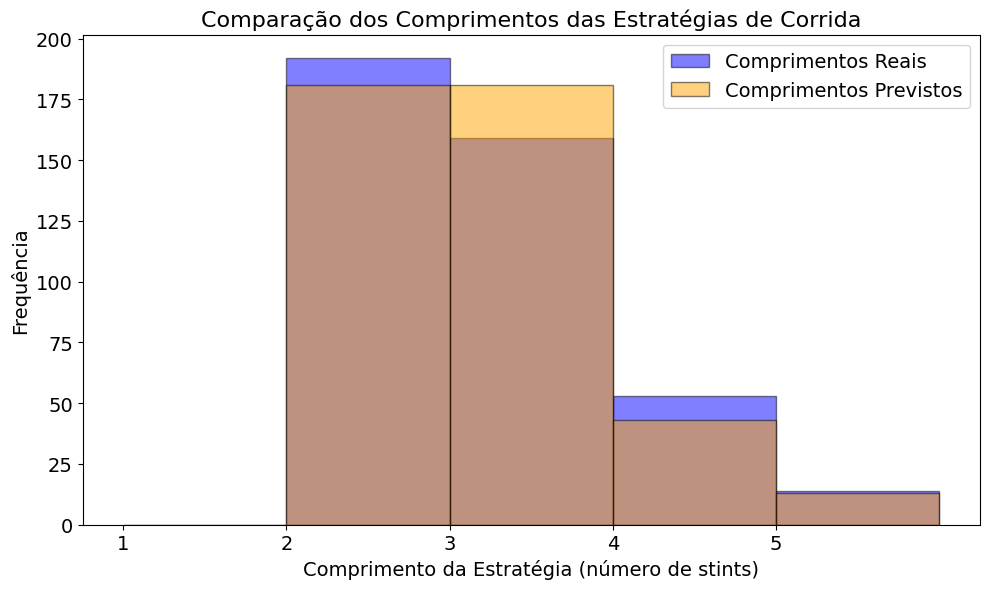

In [27]:
# plote os lens de cada estratégia num histograma com cores diferentes para os reais e os previstos.
def plot_strategy_lengths_comparison(df: pd.DataFrame, font_size: int = 14) -> None:
    """
    Plota um histograma comparando os comprimentos reais e previstos das estratégias de corrida.
    
    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame contendo as estratégias previstas e reais.
    font_size : int, opcional
        Tamanho base da fonte para o título, rótulos e ticks (padrão: 14).
    """
    # Remove 'NONE' entries from each list to count actual stints
    df_copy = df.copy()
    df_copy['Lengths_Actual'] = df_copy['Compound_Actual'].apply(lambda x: sum(1 for item in x if item != 'NONE'))
    df_copy['Lengths_Predicted'] = df_copy['Compound_Predicted'].apply(lambda x: sum(1 for item in x if item != 'NONE'))
    
    # Find the maximum length for setting up bins
    max_length = max(df_copy['Lengths_Actual'].max(), df_copy['Lengths_Predicted'].max())
    
    # Cria o histograma
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="none")
    ax.set_facecolor("none")
    
    # Create histograms with proper bins
    bins = range(1, max_length + 2)  # +2 to include the last value
    ax.hist(df_copy['Lengths_Actual'], bins=bins, 
            alpha=0.5, label='Comprimentos Reais', color='blue', edgecolor='black')
    ax.hist(df_copy['Lengths_Predicted'], bins=bins,
            alpha=0.5, label='Comprimentos Previstos', color='orange', edgecolor='black')
    
    # Add labels and styling
    ax.set_title('Comparação dos Comprimentos das Estratégias de Corrida', fontsize=font_size + 2)
    ax.set_xlabel('Comprimento da Estratégia (número de stints)', fontsize=font_size)
    ax.set_ylabel('Frequência', fontsize=font_size)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.legend(fontsize=font_size)
    
    # Set x-ticks to be integers only
    ax.set_xticks(range(1, max_length + 1))
    
    plt.tight_layout()
    plt.show()

# Plot the histogram
plot_strategy_lengths_comparison(simplified_df)

In [16]:
lengths_comp_df

,Length_1_Actual,Length_1_Predicted,Length_2_Actual,Length_2_Predicted,Length_3_Actual,Length_3_Predicted,Length_4_Actual,Length_4_Predicted,Length_5_Actual,Length_5_Predicted
383,21,24,21,28,23,9,0,0,0,0
738,12,13,14,25,20,8,0,0,0,0
1831,9,13,22,22,24,17,0,9,0,3
1651,26,24,6,5,1,3,30,10,0,16
2050,8,12,16,18,20,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
945,9,11,38,25,1,6,3,3,0,0
2111,58,38,19,36,0,0,0,1,0,0
213,36,13,35,38,0,17,0,0,0,0
845,27,26,26,26,0,18,0,14,0,0


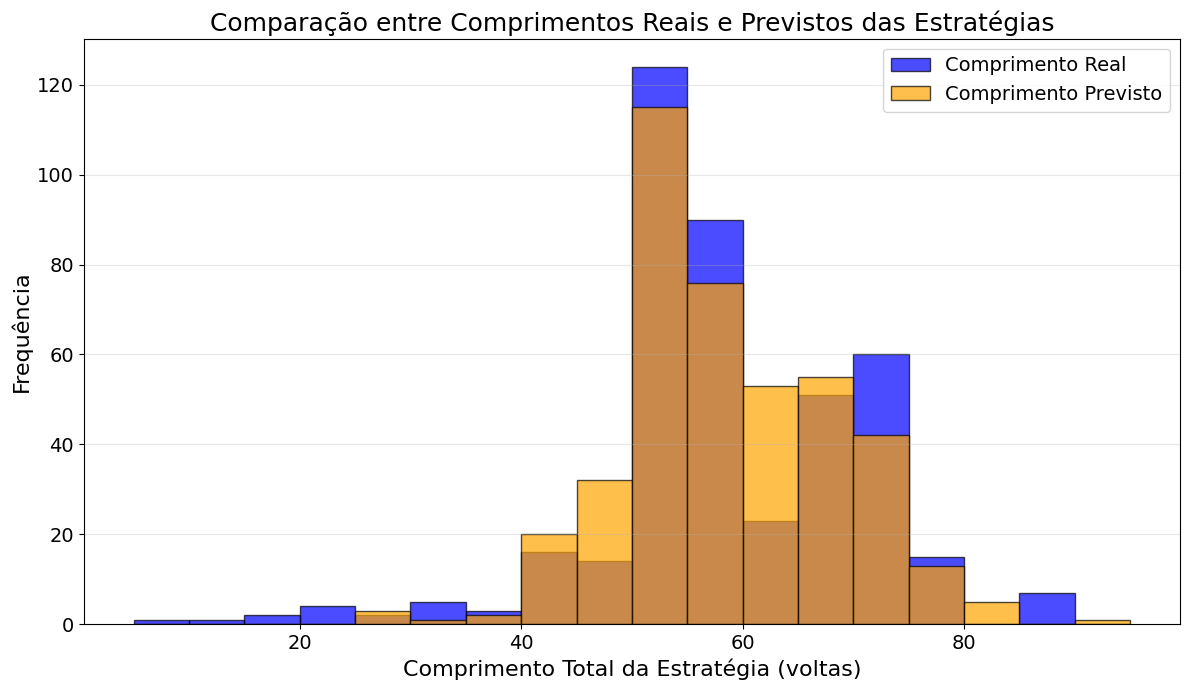

In [29]:
def comparar_comprimentos_estrategias(df: pd.DataFrame, tamanho_fonte: int = 14) -> None:
    """
    Cria um histograma comparando os comprimentos totais reais e previstos das estratégias de corrida.
    
    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame contendo as colunas 'Length_Actual' e 'Length_Predicted'
    tamanho_fonte : int, opcional
        Tamanho base da fonte para o título, rótulos e ticks (padrão: 14).
    """
    # Configuração do gráfico
    plt.figure(figsize=(12, 7), facecolor="none")
    ax = plt.gca()
    ax.set_facecolor("none")
    
    # Determinar o range dos bins baseado nos dados
    min_val = min(df['Length_Actual'].min(), df['Length_Predicted'].min())
    max_val = max(df['Length_Actual'].max(), df['Length_Predicted'].max())
    
    # Arredondar para criar bins mais limpos (múltiplos de 5)
    min_bin = min_val - min_val % 5
    max_bin = max_val + (5 - max_val % 5) if max_val % 5 != 0 else max_val
    
    # Criar bins
    bins = range(min_bin, int(max_bin) + 6, 5)
    
    # Plotar histogramas sobrepostos com transparência
    plt.hist(df['Length_Actual'], bins=bins, alpha=0.7, 
            label='Comprimento Real', color='blue', edgecolor='black')
    plt.hist(df['Length_Predicted'], bins=bins, alpha=0.7,
            label='Comprimento Previsto', color='orange', edgecolor='black')
    
    # Adicionar título e rótulos
    plt.title('Comparação entre Comprimentos Reais e Previstos das Estratégias', 
                fontsize=tamanho_fonte + 4)
    plt.xlabel('Comprimento Total da Estratégia (voltas)', fontsize=tamanho_fonte + 2)
    plt.ylabel('Frequência', fontsize=tamanho_fonte + 2)
    
    # Adicionar legenda
    plt.legend(fontsize=tamanho_fonte)
    
    # Ajustar os eixos
    plt.xticks(fontsize=tamanho_fonte)
    plt.yticks(fontsize=tamanho_fonte)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plotar o histograma de comparação
comparar_comprimentos_estrategias(simplified_lengths_df)
